In [1]:
import os

from notebooks.retrieve2 import graph_builder
from src.core.config import get_settings
os.chdir('/')
get_settings.cache_clear()
settings = get_settings()

In [40]:
from agent.tools import vs
from langchain_core.documents import Document
from langgraph.prebuilt.chat_agent_executor import AgentState
from typing import Annotated, List
from langchain_core.tools import tool

def reduce_str(x: str) -> str:
    return x.replace('##', '').strip()

class DocumentState(AgentState):
    doctype: Annotated[str, reduce_str]

@tool
def retriever(
        query: str,
        digest: str,
) -> List[Document]:
    """Retrieve documents from the vector store.

    Args:
        query: The query string.
        :param query:
        :param digest:
        :param state:

    """
    kwargs = {
        'filter': {'digest': digest},
    }

    return vs.search(query, 'similarity', **kwargs)

In [43]:
docs = retriever.invoke({'query': 'Welche company', 'digest': digest_hr})

In [53]:
from langgraph.constants import START, END
import json
from langgraph.graph import StateGraph, add_messages
from typing import TypedDict
from langchain_core.messages import ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
tools = [retriever]

llm_with_tools = model.bind_tools(tools)

def chatbot(state: State):
    return {'messages': llm_with_tools.invoke(state['messages'])}

graph_builder.add_node(chatbot)
graph_builder.add_edge(START, chatbot)
graph_builder.add_edge(chatbot, END)
graph_builder.compile()



TypeError: 'function' object is not iterable

In [51]:
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = (tool.name for tool in tools)

    def __call__(self, inputs: dict):
        if messages := inputs.get('messages', []):
            message = messages[-1]
        else:
            raise ValueError('No messages found in inputs')
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])
            outputs.append(ToolMessage(
                name=tool_call['name'],
                content=json.dumps(tool_result),
                tool_call_id=tool_call['id']
            ))
        return {'messages': outputs}

tool_node = BasicToolNode(tools)
graph_builder.add_node('tools', tool_node)


AIMessage(content='Sonstige Rechtsverhältnisse:\n\nMit der Germania GmbH mit Sitz in Berlin (Amtsgericht Charlottenburg HRB 36569) ist am 15.12.2017 ein Gewinnabführungsvertrag abgeschlossen worden. Dem hat die Gesellschafterversammlung vom 15.12.2017 zugestimmt. Die Gesellschaft ist als übernehmender Rechtsträger aufgrund des Verschmelzungsvertrages vom 02.09.2020 sowie der Zustimmungsbeschlüsse der beteiligten Rechtsträger vom selben Tag mit der Astora Beteiligungs‑GmbH mit Sitz in Kassel (Amtsgericht Kassel HRB 15690) verschmolzen.\n\nHinweis: Ich habe offensichtliche OCR‑Fehler und Sonderzeichen bereinigt und Datums‑/Begriffsannahmen (z. B. 15.12.2017) aus dem Kontext korrigiert. Wenn eine andere Jahreszahl oder ein anderer Begriff gemeint war, sagen Sie bitte Bescheid.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1177, 'prompt_tokens': 291, 'total_tokens': 1468, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_

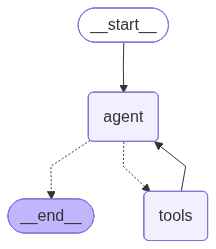

In [47]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model


SYSTEM_PROMPT = """You are a helpful assistant. Identify the document type using the retrieved documents. When you are uncertain, try a different set of documents or ask for clarification."""

model = init_chat_model(model='openai:gpt-5-mini', temperature=0)
tools = [retriever]

agent = create_react_agent(
    model=model,
    tools=tools,
    prompt=SYSTEM_PROMPT,
).with_config({'recursion_limit': 20})

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [35]:
from notebooks.utils import format_messages
from langchain_core.messages import HumanMessage

digest_hr = 'dkGJT3drmokocKeOni90TR9qsgdIURN6kTmBFe0lnfU='
digest_ar = 'vI7EHYpQg6bnz2PsLviZVeneXbMs9iqDQyOgUjIhClc='

msg = {'messages': HumanMessage(f'What is the document type for digest {digest_ar}')}
# msg = HumanMessage(content=f'What is the document type for digest {digest_ar}')

result = agent.invoke(msg)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is the document type for digest vI7EHYpQg6bnz2PsLviZVeneXbMs9iqDQyOgUjIhClc=                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: retriever                                                                                         │
│    Args: {                                                                                                      │
│   "query": "document type",                                                                                     │
│   "digest": "vI7EHYpQg6bnz2PsLviZVeneXbMs9iqDQyOgUjIhClc="                                                      │
│ }                                                                                                               │
│    ID: call_uDgwJtZR0ZL9CWyB0w2Swaze                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 1 validation error for retriever                                                                         │
│ state.doctype                                                                                                   │
│   Field required [type=missing, input_value={'messages': [HumanMessag..., 'remaining_steps': 19},               │
│ input_type=dict]                                                                                                │
│     For further information visit https://errors.pydantic.dev/2.11/v/missing                                    │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: retriever                                                                                         │
│    Args: {                                                                                                      │
│   "query": "What is the document type for this digest?",                                                        │
│   "digest": "vI7EHYpQg6bnz2PsLviZVeneXbMs9iqDQyOgUjIhClc=",                                                     │
│   "state": {                                                                                                    │
│     "doctype": ""                                                                                               │
│   }                                                                                                             │
│ }                                                                                                               │
│    ID: call_Yadvj4669Xz96ATSUt8XeMyk                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 1 validation error for retriever                                                                         │
│ state.doctype                                                                                                   │
│   Field required [type=missing, input_value={'messages': [HumanMessag..., 'remaining_steps': 17},               │
│ input_type=dict]                                                                                                │
│     For further information visit https://errors.pydantic.dev/2.11/v/missing                                    │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: retriever                                                                                         │
│    Args: {                                                                                                      │
│   "query": "vI7EHYpQg6bnz2PsLviZVeneXbMs9iqDQyOgUjIhClc=",                                                      │
│   "digest": "vI7EHYpQg6bnz2PsLviZVeneXbMs9iqDQyOgUjIhClc=",                                                     │
│   "state": {                                                                                                    │
│     "doctype": "unknown"                                                                                        │
│   }                                                                                                             │
│ }                                                                                                               │
│    ID: call_OTRMtcBPKG05zOg3Pto2zBqK                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 1 validation error for retriever                                                                         │
│ state.doctype                                                                                                   │
│   Field required [type=missing, input_value={'messages': [HumanMessag..., 'remaining_steps': 15},               │
│ input_type=dict]                                                                                                │
│     For further information visit https://errors.pydantic.dev/2.11/v/missing                                    │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: retriever                                                                                         │
│    Args: {                                                                                                      │
│   "query": "What is the document type for this digest: vI7EHYpQg6bnz2PsLviZVeneXbMs9iqDQyOgUjIhClc=",           │
│   "digest": "vI7EHYpQg6bnz2PsLviZVeneXbMs9iqDQyOgUjIhClc=",                                                     │
│   "state": {                                                                                                    │
│     "doctype": "unknown",                                                                                       │
│     "messages": [],                                                                                             │
│     "remaining_steps": 0                                                                                        │
│   }                                                                                                             │
│ }                                                                                                               │
│    ID: call_CKpuh5CBSMAOjORos35O3FAG                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: 1 validation error for retriever                                                                         │
│ state.doctype                                                                                                   │
│   Field required [type=missing, input_value={'messages': [HumanMessag..., 'remaining_steps': 13},               │
│ input_type=dict]                                                                                                │
│     For further information visit https://errors.pydantic.dev/2.11/v/missing                                    │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I tried to look up that digest in the document store but the retrieval call failed due to a                     │
│ technical/validation error (the retriever API expects a specific state field). I can't determine the document   │
│ type without either successfully fetching the document or seeing the document content.                          │
│                                                                                                                 │
│ You can choose one:                                                                                             │
│ - I can try the retrieval again (I may need additional system parameters; if you want this, say “try again”).   │
│ - Or paste the document text (or the first few lines) here and I’ll identify the type.                          │
│                                                                                                                 │
│ Which would you prefer?                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯